In [41]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv('adult.csv')
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         48842 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [8]:
data['workclass'].unique()

array(['Private', 'Local-gov', '?', 'Self-emp-not-inc', 'Federal-gov',
       'State-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [9]:
data['race'].unique()

array(['Black', 'White', 'Asian-Pac-Islander', 'Other',
       'Amer-Indian-Eskimo'], dtype=object)

In [11]:
pandas_profiling.ProfileReport(data)

Number of variables,15
Number of observations,48842
Total Missing (%),0.0%
Total size in memory,5.6 MiB
Average record size in memory,120.0 B
Numeric,6
Categorical,9
Boolean,0
Date,0
Text (Unique),0
Rejected,0


В ходе анализа отчета можем заключить следующее: столбцы capital-gain  и capital-loss можем удалить, так как больше 90% значений в них нули. Имее 52 дубликатов от которых нужно избавиться.educational-num не несет смысловой нагрузки удаляем.не очень поняла про fnlwgt, с уровнем дохода явно не коррелирует, так что удалим. Возрастно плотно расположен в основном в пределах 40-45. Классыне сбалансированы, дохода меньше 50 почти втрое больше, чем больше 50. Некоторые native-country отсутствуют и обозначены как ?. Так как таких немного от общего количества (857), можно подумать над удалением таких строчек. В occupation также есть ?. Но так как таких строчек достаточно много (2809) можно оставить и заменить на undefined для ясности. Замена пропусков на ? встречается во многих категориальных переменных в датасете.

Посмотрим, в каких точно признаках, отсутствующие значения заменены на ? и сколько таких значений

In [9]:
data.apply(lambda x: x == '?').sum()

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

Удалим строки с ? у native-country, так как таких строк относитель немного

In [33]:
len(data)

48842

In [10]:
data_clean = data.drop(data[data['native-country'].str.strip() == '?'].index)

In [42]:
len(data_clean)

47985

Удалим ненужные столбцы

In [11]:
data_clean.drop(['capital-gain', 'capital-loss','fnlwgt','educational-num'],axis=1, inplace=True)

In [12]:
data_clean.head()

,age,workclass,education,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,income
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,40,United-States,<=50K
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,40,United-States,>50K
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,40,United-States,>50K
4,18,?,Some-college,Never-married,?,Own-child,White,Female,30,United-States,<=50K


Кодируем значения

Для race gender income применим LabelIncoder, для остальных One-Hot Encoder

In [13]:
le = LabelEncoder()

In [14]:
def label_value(data,le):
    print("Label {}".format(data.columns.values[0]))
    le.fit(data)
    print('Labeled classes {}'.format(le.classes_))
    return le.transform(data)

In [15]:
data_clean['labeled_gender'] = label_value(data_clean[['gender']],le)

Label gender
Labeled classes ['Female' 'Male']


In [16]:
data_clean['labeled_income'] = label_value(data_clean[['income']],le)

Label income
Labeled classes ['<=50K' '>50K']


In [17]:
data_clean.drop(['income','gender'],axis=1,inplace=True)

In [18]:
data_clean.head()

,age,workclass,education,marital-status,occupation,relationship,race,hours-per-week,native-country,labeled_gender,labeled_income
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,40,United-States,1,0
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,50,United-States,1,0
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,40,United-States,1,1
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,40,United-States,1,1
4,18,?,Some-college,Never-married,?,Own-child,White,30,United-States,0,0


In [19]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47985 entries, 0 to 48841
Data columns (total 11 columns):
age               47985 non-null int64
workclass         47985 non-null object
education         47985 non-null object
marital-status    47985 non-null object
occupation        47985 non-null object
relationship      47985 non-null object
race              47985 non-null object
hours-per-week    47985 non-null int64
native-country    47985 non-null object
labeled_gender    47985 non-null int64
labeled_income    47985 non-null int64
dtypes: int64(4), object(7)
memory usage: 4.4+ MB


In [20]:
def hot_encode(df):
    obj_df = df.select_dtypes(include=['object'])
    return pd.get_dummies(df, columns=obj_df.columns)

In [21]:
data_clean = hot_encode(data_clean)

In [22]:
data_clean.head()

,age,hours-per-week,labeled_gender,labeled_income,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,40,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,38,50,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,28,40,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,44,40,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,18,30,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Feature Selection

### PCA

In [111]:
from sklearn.decomposition import PCA

In [112]:
y = pd.Series(data_clean['labeled_income'])

In [113]:
X = data_clean.drop('labeled_income',axis=1)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.3, random_state=42)

Приведем наши данные к одному масштабу

In [115]:
scaler = StandardScaler()
X_scaled = scaler.fit(X_train)
x_train_scaled=  X_scaled.transform(X_train)
x_test_scaled = X_scaled.transform(X_test)

Попробуем сначала визуализировать наши данные с помощью PCA. Для этого выделим две главные компоненты

In [116]:
pca = PCA(n_components=2)
pca.fit(x_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [117]:
X_train_pca = pca.transform(x_train_scaled)
X_test_pca = pca.transform(x_test_scaled)

In [118]:
x_train_scaled.shape

(33589, 102)

In [37]:
X_train_pca.shape

(33589, 2)

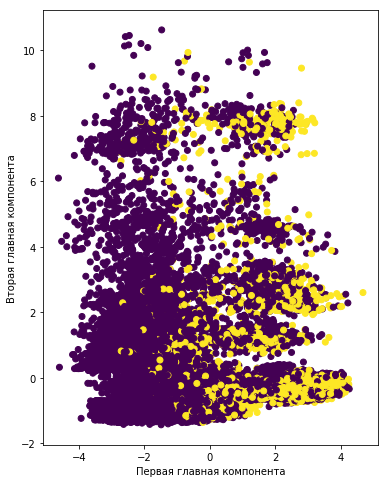

In [42]:
plt.figure(figsize=(8,8))
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c=y_train)
plt.gca().set_aspect('equal')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента');

Применение только двух первых главных компонент плохо разделяет классы.

Посмотрим сколько компонент нужно, чтобы объяснить большую часть дисперсии данных

In [119]:
pca = PCA(whiten=True,random_state=42).fit(x_train_scaled)
X_train_pca = pca.transform(x_train_scaled)
X_test_pca = pca.transform(x_test_scaled)

Text(0,0.5,'explained_variance_ratio_')

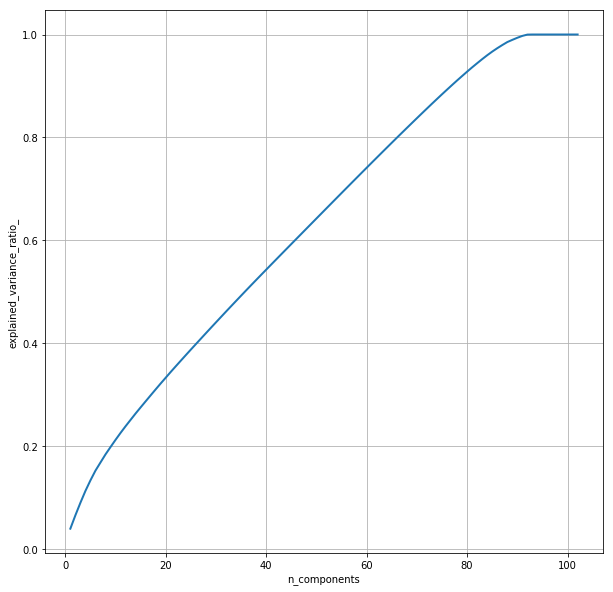

In [124]:
plt.rcParams['figure.figsize'] = (10, 10)

cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

По графику можем видеть, что нам достаточно взять порядка 90 компонент, чтобы объяснить всю дисперсию в данных

In [121]:
pca_final = PCA(n_components = 93, whiten=True,random_state=42).fit(x_train_scaled)
X_train_pca = pca_final.transform(x_train_scaled)
X_test_pca = pca_final.transform(x_test_scaled)

Получим оценку

In [122]:
score_pca = LogisticRegression(random_state=0).fit(X_train_pca,y_train).score(X_test_pca, y_test)

In [123]:
score_pca

0.8321756043345374

### Using DesicionTrees for feature importance

In [240]:
from sklearn.ensemble import ExtraTreesClassifier

In [241]:
model = ExtraTreesClassifier()
model.fit(X_train, y_train)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

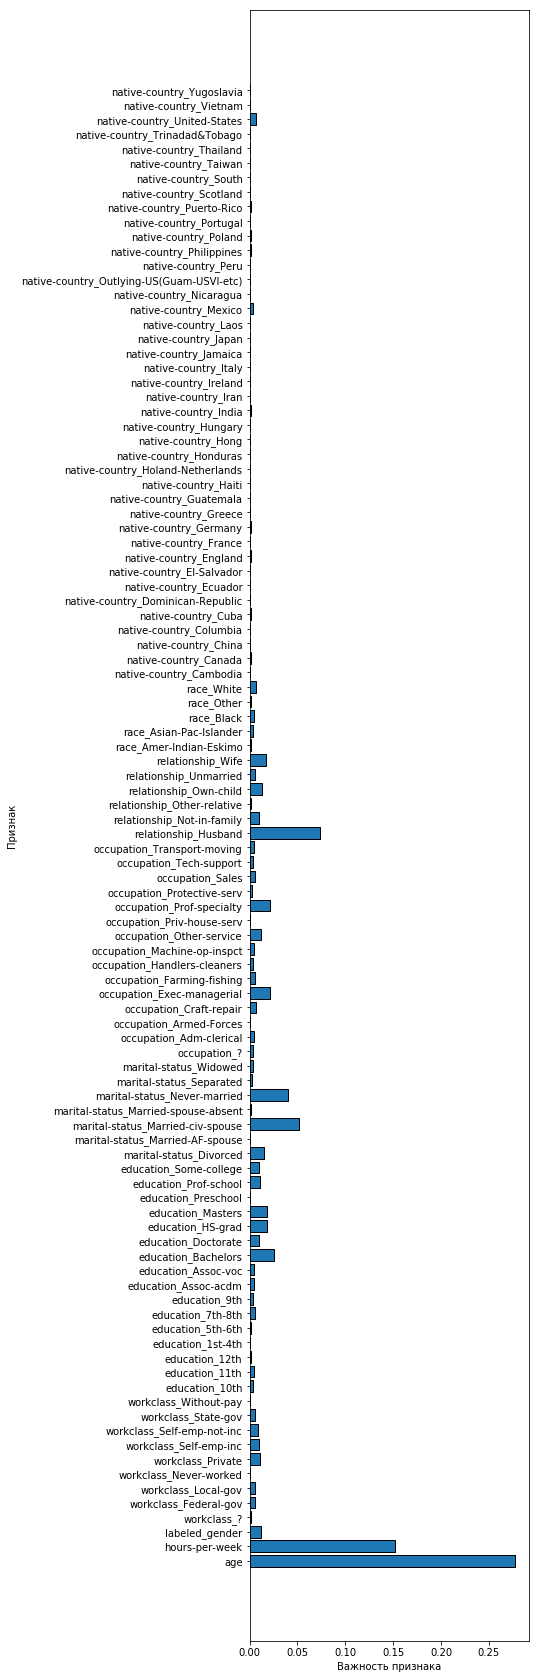

In [242]:
plt.rcParams['figure.figsize'] = (5, 30)

def plot_feature_importances(model):
    n_features = len(X_train.columns)
    plt.barh(range(n_features),model.feature_importances_,ec="black",align='center')
    plt.yticks(np.arange(n_features),X_train.columns)
    plt.xlabel("Важность признака")
    plt.ylabel("Признак")
 
plt.tight_layout()
plot_feature_importances(model)

In [128]:
np.argsort(model.feature_importances_)[-100:]

array([ 76,  37,  88,  98,  94,  97,  25,  77,  85,  87,  74,  44,  67,
        89,  96,  73, 101,  11,  92, 100,  81,  83,  70,  78,  61,  66,
        68,  64,  29,  80,  72,  95,  84,  91,  63,  15,  69,  82,  65,
        90,  79,  93,  71,  31,  14,  59,  35,  62,  56,  16,  34,   3,
        46,  57,  41,  33,  86,  52,  18,  48,  12,  20,  19,  42,  49,
        36,  58,  10,  13,  40,  17,   4,   5,  47,  99,  38,  60,  27,
        22,  54,   9,   8,   7,  55,   2,  26,  28,  43,  23,  24,  53,
        51,  45,  39,  21,  32,  30,  50,   1,   0], dtype=int64)

Попробуем применить меньше признаков, чем в pca

In [243]:
columns_to_use= X_train.columns[np.argsort(model.feature_importances_)[-90:]]

In [244]:
X_train_trees = X_train[columns_to_use]
X_test_trees = X_test[columns_to_use]

In [245]:
scaler = StandardScaler()
scaler.fit(X_train_trees)
X_train_tree_scaled=  scaler.transform(X_train_trees)
X_test_trees_scaled = scaler.transform(X_test_trees)

In [246]:
score_tree = LogisticRegression(random_state=0).fit(X_train_tree_scaled,y_train).score(X_test_trees_scaled, y_test)

In [247]:
score_tree

0.8321756043345374

In [248]:
score_tree > score_pca

False

С 90 признаками модель отрабатывает хуже. Попробуем взять 93 и 94

In [249]:
def compare_pca_tree(cnt_features):
    columns_to_use= X_train.columns[np.argsort(model.feature_importances_)[-cnt_features:]]
    X_train_trees = X_train[columns_to_use]
    X_test_trees = X_test[columns_to_use]
    scaler = StandardScaler()
    scaler.fit(X_train_trees)
    X_train_tree_scaled=  scaler.transform(X_train_trees)
    X_test_trees_scaled = scaler.transform(X_test_trees)
    score_tree = LogisticRegression(random_state=0).fit(X_train_tree_scaled,y_train).score(X_test_trees_scaled, y_test)
    print('Does tree model perfom better? Answer: %s' % (score_tree > score_pca))
    answer = score_tree > score_pca
    return answer

In [250]:
compare_pca_tree(93)

Does tree model perfom better? Answer: False


False

In [251]:
compare_pca_tree(94)

Does tree model perfom better? Answer: False


False

Найдем количество признаков, при котором можель показывает улучшение

In [252]:
cnt_feaut = 0
for i in range(95,len(X_train.columns) + 1):
    ans = compare_pca_tree(i)
    if ans:
        cnt_feaut = i
        break

Does tree model perfom better? Answer: False
Does tree model perfom better? Answer: False
Does tree model perfom better? Answer: False
Does tree model perfom better? Answer: True


In [253]:
cnt_feaut

98

При 98 признаках модель начинает улучшать показатели с pca.Запомним оценку с 98 признаками

In [254]:
columns_to_use= X_train.columns[np.argsort(model.feature_importances_)[-98:]]
X_train_trees = X_train[columns_to_use]
X_test_trees = X_test[columns_to_use]
scaler = StandardScaler()
scaler.fit(X_train_trees)
X_train_tree_scaled=  scaler.transform(X_train_trees)
X_test_trees_scaled = scaler.transform(X_test_trees)
score_tree_best = LogisticRegression(random_state=0).fit(X_train_tree_scaled,y_train).score(X_test_trees_scaled, y_test)


### L-1 based features selection and SelectFromModel

In [208]:
from sklearn.feature_selection import SelectFromModel

In [216]:
logreg_for_fselection = LogisticRegression(random_state=0,C=0.01, penalty="l1").fit(X, y)
model = SelectFromModel(logreg_for_fselection,prefit=True)

X_new = model.transform(X)

In [217]:
X_new.shape

(47985, 30)

In [218]:
X_train_new, X_test_new, y_train, y_test = train_test_split(X_new, y,stratify=y, test_size=0.3, random_state=42)

In [220]:
scaler = StandardScaler()
scaler.fit(X_train_new)
X_train_new_scaled=  scaler.transform(X_train_new)
X_test_new_scaled = scaler.transform(X_test_new)

In [221]:
l1_score = LogisticRegression(random_state=0).fit(X_train_new_scaled,y_train).score(X_test_new_scaled, y_test)

In [222]:
l1_score > score_tree_best

False

In [223]:
l1_score

0.831133648235621

In [224]:
score_tree_best

0.8323145318143929

Модель отобрала 30 признаков и с таким набором оценка ожидаемо хуже при испольовании той же самой логистической регрессии с теми же самыми параметрами. Посмотрим, какие колонки отобрала модель

In [228]:
X.columns[model.get_support()]

Index(['age', 'hours-per-week', 'labeled_gender', 'workclass_Federal-gov',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'education_10th', 'education_11th', 'education_7th-8th',
       'education_Bachelors', 'education_Doctorate', 'education_HS-grad',
       'education_Masters', 'education_Prof-school',
       'marital-status_Married-civ-spouse', 'marital-status_Never-married',
       'occupation_?', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Prof-specialty', 'occupation_Sales',
       'occupation_Tech-support', 'relationship_Own-child',
       'relationship_Unmarried', 'relationship_Wife', 'race_Black',
       'native-country_Mexico'],
      dtype='object')

# Recursive feature elimination with cross-validation

Optimal number of features : 102


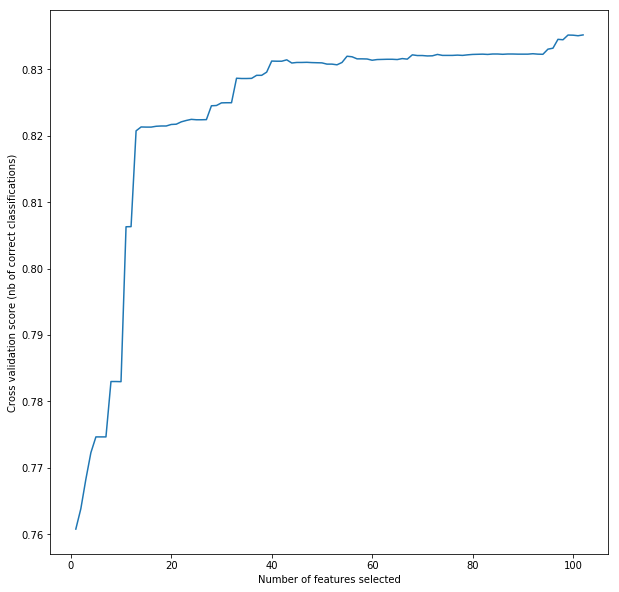

In [230]:
plt.rcParams['figure.figsize'] = (10, 10)

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV


logreg_for_rfe = LogisticRegression(random_state=0)

rfecv = RFECV(estimator=logreg_for_rfe, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Иными словами, использвоание rfe показало, что оптимально будет использовать все признаки в модели. Сравним оценки

In [233]:
X_train_rfe, X_test_rfe, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.3, random_state=42)

In [235]:
scaler = StandardScaler()
scaler.fit(X_train_rfe)
X_train_rfe_scaled=  scaler.transform(X_train_rfe)
X_test_rfe_scaled = scaler.transform(X_test_rfe)

In [236]:
rfe_score = LogisticRegression(random_state=0).fit(X_train_rfe_scaled,y_train).score(X_test_rfe_scaled, y_test)

In [237]:
rfe_score > score_tree_best

False

In [238]:
rfe_score

0.8322450680744651

In [239]:
score_tree_best

0.8323145318143929

Однако по оценками score, 96 фич все же дают лучший результат. Поэтому остановимся на 98 фичах, которые мы получили при оценке важности признаков через деревья

# Построение модели

Используем при построении и валидации можели то подмножество фич, которые выбрали из построения моедели деревьев (всего 98 признаков)

In [255]:
logreg = LogisticRegression(random_state = 121)

In [ ]:

X_train_tree_scaled=  scaler.transform(X_train_trees)
X_test_trees_scaled = scaler.transform(X_test_trees)
score_tree_best = LogisticRegression(random_state=0).fit(X_train_tree_scaled,y_train).score(X_test_trees_scaled, y_test)


Делаем финальные предсказания

In [ ]:
grid_obj = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)
grid_obj = grid_obj.fit(X_train_tree_scaled, y_train)

clf = grid_obj.best_estimator_

clf.fit(X_train_tree_scaled, y_train)

predictions = clf.predict(X_test_trees_scaled)

In [259]:
from sklearn.metrics import accuracy_score

In [260]:
print(accuracy_score(y_test, predictions))

0.8321756043345374
